In [8]:
# if you want to remove any folder
#import shutil
#shutil.rmtree('/content/preprocessed_images/no/')

In [1]:
! unzip 'brain_tumor_dataset.zip'

Archive:  brain_tumor_dataset.zip
   creating: brain_tumor_dataset/
  inflating: __MACOSX/._brain_tumor_dataset  
  inflating: brain_tumor_dataset/.DS_Store  
  inflating: __MACOSX/brain_tumor_dataset/._.DS_Store  
   creating: brain_tumor_dataset/no/
  inflating: __MACOSX/brain_tumor_dataset/._no  
   creating: brain_tumor_dataset/yes/
  inflating: __MACOSX/brain_tumor_dataset/._yes  
  inflating: brain_tumor_dataset/no/30 no.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._30 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._22 no.jpg  
  inflating: brain_tumor_dataset/no/41 no.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._41 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._14 no.jpg  
  inflating: brain_tumor_dataset/no/no 10.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._no 10.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: __MACOSX/brain_

In [2]:
import cv2
import imutils
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import collections
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from tensorflow.keras.models import Model,load_model


In [3]:
def preprocess_brain_mri(image ,img_size, plot=False):
    
    #  image_width, image_height = image_size
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    new_image = cv2.resize(new_image, img_size, interpolation=cv2.INTER_CUBIC)
    # normalize values
    new_image = new_image / 255.
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image  

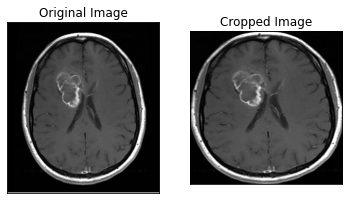

In [4]:
img1='/content/brain_tumor_dataset/yes/Y101.jpg'
img=cv2.imread(img1)
a=(246,246)
p=preprocess_brain_mri(img,a,True)

In [5]:
image_path ='/content/brain_tumor_dataset/'


In [9]:
# creating new directories for preprocessed images 
os.makedirs('/content/preprocessed_images/')
os.makedirs('/content/preprocessed_images/yes/')
os.makedirs('/content/preprocessed_images/no/')


In [10]:
#new paths for preprocessed images
new_path='/content/preprocessed_images/'
new_path_yes='/content/preprocessed_images/yes/'
new_path_no='/content/preprocessed_images/no/'

#original image path
image_path_yes='/content/brain_tumor_dataset/'+'yes'
image_path_no='/content/brain_tumor_dataset/'+'no'


In [11]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [12]:
augment_data(file_dir=image_path_yes,n_generated_samples=3,save_to_dir=new_path_yes)

In [13]:
augment_data(file_dir=image_path_no,n_generated_samples=4,save_to_dir=new_path_no)

In [14]:
def load_format_data (input_path,size):
  brain_image=[]
  label=[]
  for class_name in os.listdir(input_path):
    print(input_path,class_name)
    for dir_data in os.listdir(input_path+class_name):
      image= cv2.imread(input_path+class_name+'/'+dir_data)
      image= preprocess_brain_mri(image,size,False)
      brain_image.append(image)
      if class_name[-3:]=='yes':
        label.append(1)
      else:
        label.append(0)


  brain_image=np.array(brain_image)
  label=np.array(label)
  brain_image,label=shuffle(brain_image,label)
  
  print('Total brain_images',len(brain_image))
  print('shape of brain_image and label', brain_image.shape,label.shape)

  return brain_image,label





In [15]:
x,y = load_format_data(new_path,(256,256))

/content/preprocessed_images/ yes
/content/preprocessed_images/ no
Total brain_images 1110
shape of brain_image and label (1110, 256, 256, 3) (1110,)


In [31]:
def plot_data(data,lbl,n=10):
  a=collections.Counter(lbl)
  for val in a.keys():
    image= x[y==val]
    n_image=image[:n]
    plt.figure(figsize=(10, 8))
    
    col=2
    rows=int(n/col)
    i = 1
    for img in n_image:
      plt.subplot(rows,col,i)
      plt.imshow(img)
      plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
      i += 1

    label_to_str = lambda val: "Yes" if val == 1 else "No"
    plt.suptitle(f"Brain Tumor: {label_to_str(val)}")
    plt.show()


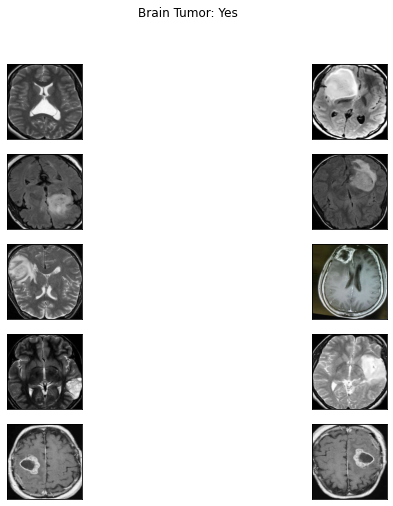

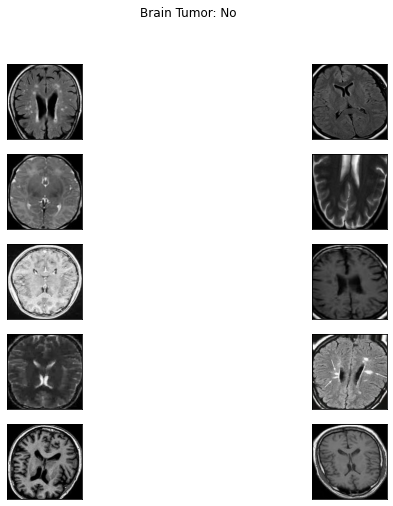

In [32]:
plot_data(x,y,10)

In [20]:
X_train, X_test_val, y_train, y_test_val = train_test_split(x, y, test_size=0.2)

In [22]:
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

In [23]:
print(len(X_test))
print(len(X_val))
print(len(y_test))
print(len(y_val))

111
111
111
111


In [51]:
# Create model
X_input = Input((256,256,3)) 
X = ZeroPadding2D((2, 2))(X_input) 

X = Conv2D(32, (3, 3), strides = (1, 1))(X)
X = BatchNormalization(axis = 3, name = 'bn0')(X)
X = Activation('relu')(X) 

X = MaxPooling2D((2, 2))(X) 
X = MaxPooling2D((2, 2))(X) 
X = Flatten()(X) 
X = Dense(1, activation='sigmoid')(X) 
model = Model(inputs = X_input, outputs = X)



In [52]:
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 260, 260, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 258, 258, 32)      896       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 258, 258, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 258, 258, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 129, 129, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)       

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [54]:
model.fit(x=X_train, y=y_train, batch_size=10, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
89/89 [==============================] - 54s 609ms/step - loss: 4.2121 - accuracy: 0.6216 - val_loss: 0.6836 - val_accuracy: 0.5946
Epoch 2/10
89/89 [==============================] - 56s 626ms/step - loss: 1.3011 - accuracy: 0.7804 - val_loss: 1.0657 - val_accuracy: 0.4775
Epoch 3/10
89/89 [==============================] - 56s 626ms/step - loss: 1.4469 - accuracy: 0.7849 - val_loss: 0.6646 - val_accuracy: 0.7117
Epoch 4/10
89/89 [==============================] - 54s 603ms/step - loss: 0.7564 - accuracy: 0.8514 - val_loss: 0.5881 - val_accuracy: 0.7748
Epoch 5/10
89/89 [==============================] - 54s 609ms/step - loss: 0.1882 - accuracy: 0.9369 - val_loss: 0.6708 - val_accuracy: 0.7568
Epoch 6/10
89/89 [==============================] - 55s 612ms/step - loss: 0.0592 - accuracy: 0.9786 - val_loss: 1.2550 - val_accuracy: 0.6847
Epoch 7/10
89/89 [==============================] - 54s 605ms/step - loss: 0.1094 - accuracy: 0.9673 - val_loss: 0.8341 - val_accuracy: 0.7838

In [55]:
history = model.history.history


In [56]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

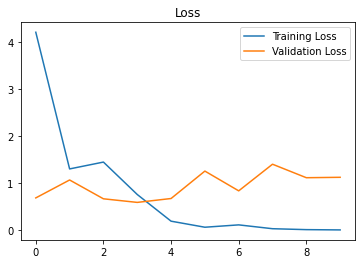

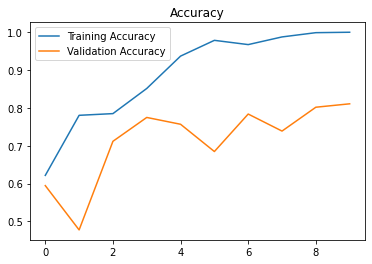

In [57]:
plot_metrics(history)
